In [1]:
# 5-Year Real Estate Price Prediction - Baltimore County, MD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme()

In [2]:
raw_path = "../data/raw/zhvi_zip_allhomes.csv"
df = pd.read_csv(raw_path)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,207990.862896,...,496241.955346,495923.501749,495027.233843,493256.614962,491089.575909,488525.475785,486477.885587,485372.312103,485572.025450,486313.753787
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,115428.100095,...,539389.412910,541328.620266,543641.012632,546961.018012,549808.083062,552401.074246,554231.272949,555507.245194,558124.481843,563140.887500
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103617.439109,...,278857.581088,278234.565344,277403.626819,276446.232480,275643.203948,274644.617583,273705.009498,272771.088086,271993.355984,271254.566351
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,172177.874323,...,526608.289830,526478.270302,526136.430970,526024.534098,526413.194506,528462.622083,531191.375180,532845.799332,534074.275678,535093.606817
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,103084.537334,...,274553.215409,274148.943029,273286.424549,272241.767228,271344.301432,270338.034427,269421.435742,268541.858499,267660.543449,266806.718546


In [3]:
df_bc = df[df["CountyName"] == "Baltimore County"].copy()
df_bc.head()
df_bc.shape

(38, 319)

In [6]:
date_cols = df_bc.columns[ df_bc.columns.str.match(r"^\d{4}-\d{2}-\d{2}$") ]
date_cols[:10]

Index(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31',
       '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31'],
      dtype='object')

In [7]:
date_cols = df_bc.columns[df_bc.columns.str.match(r"^\d{4}-\d{2}-\d{2}$")]

df_tidy = df_bc.melt(
    id_vars=["RegionID", "RegionName", "City", "State", "Metro", "CountyName"],
    value_vars=date_cols,
    var_name="Date",
    value_name="HomeValue"
)

In [8]:
df_tidy["Date"] = pd.to_datetime(df_tidy["Date"], format="%Y-%m-%d")
df_tidy = df_tidy.sort_values(["RegionName", "Date"])
df_tidy.head()

,RegionID,RegionName,City,State,Metro,CountyName,Date,HomeValue
28,66723,21013,Baldwin,MD,"Baltimore-Columbia-Towson, MD",Baltimore County,2000-01-31,254710.877258
66,66723,21013,Baldwin,MD,"Baltimore-Columbia-Towson, MD",Baltimore County,2000-02-29,255263.885077
104,66723,21013,Baldwin,MD,"Baltimore-Columbia-Towson, MD",Baltimore County,2000-03-31,255630.313885
142,66723,21013,Baldwin,MD,"Baltimore-Columbia-Towson, MD",Baltimore County,2000-04-30,256215.464466
180,66723,21013,Baldwin,MD,"Baltimore-Columbia-Towson, MD",Baltimore County,2000-05-31,256845.903045


In [9]:
df_tidy["Year"] = df_tidy["Date"].dt.year

In [10]:
df_yearly = (
    df_tidy.groupby(["RegionName", "Year"])["HomeValue"]
    .median()
    .reset_index()
    .rename(columns={"RegionName": "Zip", "HomeValue": "MedianValue"})
)
df_yearly.head()

,Zip,Year,MedianValue
0,21013,2000,259365.990902
1,21013,2001,274204.123345
2,21013,2002,299152.319648
3,21013,2003,336760.704605
4,21013,2004,384111.822749


In [11]:
df_yearly.to_csv("../data/processed/bc_yearly_home_values.csv", index=False)

In [12]:
pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
zip_code = df_yearly["Zip"].unique()[0]  # pick first ZIP

df_zip = df_yearly[df_yearly["Zip"] == zip_code].copy()
df_zip = df_zip.rename(columns={"Year": "ds", "MedianValue": "y"})

In [14]:
df_zip["ds"] = pd.to_datetime(df_zip["ds"].astype(str) + "-01-01")
df_zip.head()

,Zip,ds,y
0,21013,2000-01-01,259365.990902
1,21013,2001-01-01,274204.123345
2,21013,2002-01-01,299152.319648
3,21013,2003-01-01,336760.704605
4,21013,2004-01-01,384111.822749


In [15]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(df_zip)

19:57:46 - cmdstanpy - INFO - Chain [1] start processing
19:57:47 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=5, freq="Y")
future.tail()

,ds
26,2025-12-31
27,2026-12-31
28,2027-12-31
29,2028-12-31
30,2029-12-31


In [17]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
26,2025-12-31,593471.502894,517324.123190,672387.513199,593471.498068,593471.507607,0.0,0.0,0.0,0.0,0.0,0.0,593471.502894
27,2026-12-31,603974.320480,531224.463102,677081.005624,603974.304361,603974.336016,0.0,0.0,0.0,0.0,0.0,0.0,603974.320480
28,2027-12-31,614477.138067,537726.819876,685440.747110,614477.104852,614477.170046,0.0,0.0,0.0,0.0,0.0,0.0,614477.138067
29,2028-12-31,625008.730497,552520.277908,696986.723388,625008.677921,625008.782505,0.0,0.0,0.0,0.0,0.0,0.0,625008.730497
30,2029-12-31,635511.548083,565926.810550,704935.650578,635511.475036,635511.626140,0.0,0.0,0.0,0.0,0.0,0.0,635511.548083


In [18]:
forecast_5yr = forecast[forecast["ds"].dt.year > df_zip["ds"].dt.year.max()][["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_5yr

,ds,yhat,yhat_lower,yhat_upper
27,2026-12-31,603974.320480,531224.463102,677081.005624
28,2027-12-31,614477.138067,537726.819876,685440.747110
29,2028-12-31,625008.730497,552520.277908,696986.723388
30,2029-12-31,635511.548083,565926.810550,704935.650578


In [19]:
current_value = df_zip["y"].iloc[-1]
year5_value = forecast_5yr["yhat"].iloc[-1]

growth_5yr = (year5_value - current_value) / current_value * 100
cagr = ((year5_value / current_value) ** (1/5) - 1) * 100

current_value, year5_value, growth_5yr, cagr

(639546.8138217287,
 635511.5480834483,
 -0.6309570544440534,
 -0.12651110738717275)

In [20]:
def forecast_zip(df_yearly, zip_code):
    df_zip = df_yearly[df_yearly["Zip"] == zip_code].copy()
    df_zip = df_zip.rename(columns={"Year": "ds", "MedianValue": "y"})
    df_zip["ds"] = pd.to_datetime(df_zip["ds"].astype(str) + "-01-01")

    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.fit(df_zip)

    future = model.make_future_dataframe(periods=5, freq="Y")
    forecast = model.predict(future)

    forecast_5yr = forecast[forecast["ds"].dt.year > df_zip["ds"].dt.year.max()][["ds", "yhat"]]

    current_value = df_zip["y"].iloc[-1]
    year5_value = forecast_5yr["yhat"].iloc[-1]
    growth_5yr = (year5_value - current_value) / current_value * 100
    cagr = ((year5_value / current_value) ** (1/5) - 1) * 100

    return {
        "zip": zip_code,
        "current_value": current_value,
        "year5_value": year5_value,
        "growth_5yr_pct": growth_5yr,
        "cagr_pct": cagr,
        "forecast_table": forecast_5yr
    }

In [21]:
results = []

for z in df_yearly["Zip"].unique():
    try:
        res = forecast_zip(df_yearly, z)
        results.append(res)
    except:
        print(f"Failed for ZIP {z}")

19:59:26 - cmdstanpy - INFO - Chain [1] start processing
19:59:26 - cmdstanpy - INFO - Chain [1] done processing
19:59:26 - cmdstanpy - INFO - Chain [1] start processing
19:59:26 - cmdstanpy - INFO - Chain [1] done processing
19:59:26 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] done processing
19:59:28 - cmdstanpy - INFO - Chain [1] start processing
19:59:29 - cmdstanpy - INFO - Chain [1] done processing
19:59:29 - cmdstanpy - INFO - Chain [1] start processing
19:59:29 - cmdstanpy - INFO - Chain [1] done processing
19:59:29 - cmdstanpy - INFO - Chain [1] start processing
19:59:29 - cmdstanpy - INFO - Chain [1] done processing
19:59:29 - cmdstanpy - INFO - Chain [1] start processing
19:59:31 - cmdstanpy - INFO - Chain [1] done processing
19:59:31 - cmdstanpy - INFO - Chain [1] start processing
19:59:31 - cmdstanpy - INFO - Chain [1] done processing
19:59:31 - cmdstanpy - INFO - Chain [1] start processing
19:59:31 - cmdstanpy - INFO - Chain [1]

In [22]:
forecast_all = pd.DataFrame([{
    "Zip": r["zip"],
    "CurrentValue": r["current_value"],
    "Forecast5Yr": r["year5_value"],
    "GrowthPct5Yr": r["growth_5yr_pct"],
    "CAGR": r["cagr_pct"]
} for r in results])

forecast_all

,Zip,CurrentValue,Forecast5Yr,GrowthPct5Yr,CAGR
0,21013,6.395468e+05,6.355115e+05,-0.630957,-0.126511
1,21030,4.569150e+05,4.702980e+05,2.928994,0.579054
2,21051,5.473910e+05,6.309746e+05,15.269464,2.882819
3,21052,3.470977e+05,4.218729e+05,21.542954,3.979077
4,21053,5.515558e+05,5.700106e+05,3.345958,0.660411
5,21057,6.292366e+05,6.251760e+05,-0.645330,-0.129400
6,21071,4.988880e+05,5.178224e+05,3.795318,0.747796
7,21082,5.599319e+05,5.772137e+05,3.086399,0.609797
8,21087,5.311428e+05,5.325298e+05,0.261141,0.052174
9,21093,4.954332e+05,5.140156e+05,3.750721,0.739137


In [23]:
forecast_all.to_csv("../data/processed/forecast_summary.csv", index=False)

20:15:38 - cmdstanpy - INFO - Chain [1] start processing
20:15:38 - cmdstanpy - INFO - Chain [1] done processing


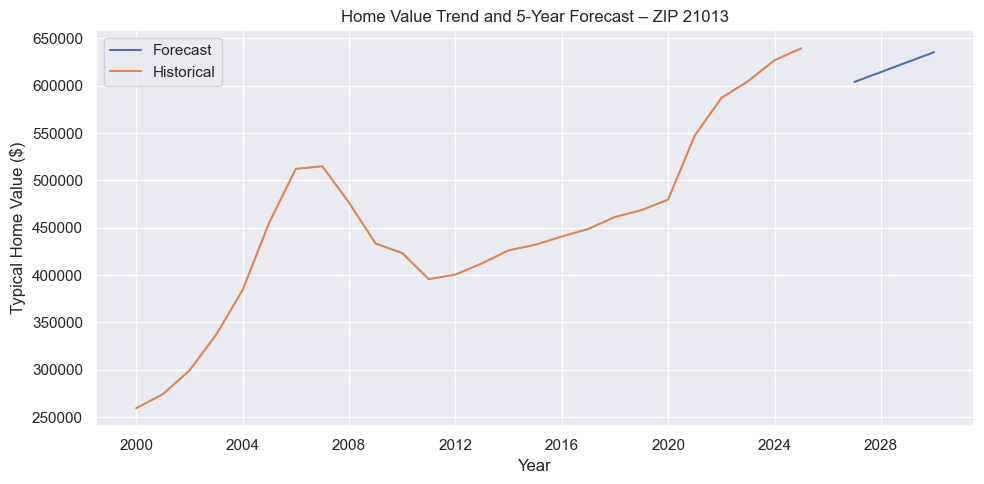

In [24]:
import matplotlib.pyplot as plt

# pick a zip to visualize
zip_code = df_yearly["Zip"].unique()[0]  # or something like "21234"

hist = df_yearly[df_yearly["Zip"] == zip_code].copy()
hist["Date"] = pd.to_datetime(hist["Year"].astype(str) + "-01-01")

# rebuild forecast for this zip (reusing your function)
res = forecast_zip(df_yearly, zip_code)
fc = res["forecast_table"].copy()
fc = fc.rename(columns={"ds": "Date", "yhat": "MedianValue"})
fc["Type"] = "Forecast"
hist_plot = hist[["Date", "MedianValue"]].copy()
hist_plot["Type"] = "Historical"

plot_df = pd.concat([hist_plot, fc[["Date", "MedianValue", "Type"]]])

plt.figure(figsize=(10, 5))
for t, g in plot_df.groupby("Type"):
    plt.plot(g["Date"], g["MedianValue"], label=t)

plt.title(f"Home Value Trend and 5-Year Forecast – ZIP {zip_code}")
plt.xlabel("Year")
plt.ylabel("Typical Home Value ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
plt.savefig("../reports/figures/zip_example_trend.png", dpi=200)

<Figure size 640x480 with 0 Axes>

In [26]:
all_rows = []

for z in df_yearly["Zip"].unique():
    # historical
    hist = df_yearly[df_yearly["Zip"] == z].copy()
    hist["Date"] = pd.to_datetime(hist["Year"].astype(str) + "-01-01")
    hist["Type"] = "Historical"
    hist = hist[["Zip", "Date", "MedianValue", "Type"]]

    # forecast
    res = forecast_zip(df_yearly, z)
    fc = res["forecast_table"].copy()
    fc = fc.rename(columns={"ds": "Date", "yhat": "MedianValue"})
    fc["Zip"] = z
    fc["Type"] = "Forecast"
    fc = fc[["Zip", "Date", "MedianValue", "Type"]]

    all_rows.append(hist)
    all_rows.append(fc)

full_ts = pd.concat(all_rows, ignore_index=True)
full_ts.sort_values(["Zip", "Date"], inplace=True)

full_ts.to_csv("../data/processed/full_timeseries_with_forecast.csv", index=False)
full_ts.head()

20:16:42 - cmdstanpy - INFO - Chain [1] start processing
20:16:42 - cmdstanpy - INFO - Chain [1] done processing
20:16:42 - cmdstanpy - INFO - Chain [1] start processing
20:16:42 - cmdstanpy - INFO - Chain [1] done processing
20:16:42 - cmdstanpy - INFO - Chain [1] start processing
20:16:43 - cmdstanpy - INFO - Chain [1] done processing
20:16:43 - cmdstanpy - INFO - Chain [1] start processing
20:16:45 - cmdstanpy - INFO - Chain [1] done processing
20:16:45 - cmdstanpy - INFO - Chain [1] start processing
20:16:45 - cmdstanpy - INFO - Chain [1] done processing
20:16:45 - cmdstanpy - INFO - Chain [1] start processing
20:16:45 - cmdstanpy - INFO - Chain [1] done processing
20:16:45 - cmdstanpy - INFO - Chain [1] start processing
20:16:47 - cmdstanpy - INFO - Chain [1] done processing
20:16:47 - cmdstanpy - INFO - Chain [1] start processing
20:16:47 - cmdstanpy - INFO - Chain [1] done processing
20:16:47 - cmdstanpy - INFO - Chain [1] start processing
20:16:47 - cmdstanpy - INFO - Chain [1]

,Zip,Date,MedianValue,Type
0,21013,2000-01-01,259365.990902,Historical
1,21013,2001-01-01,274204.123345,Historical
2,21013,2002-01-01,299152.319648,Historical
3,21013,2003-01-01,336760.704605,Historical
4,21013,2004-01-01,384111.822749,Historical


In [27]:
forecast_all.head()

,Zip,CurrentValue,Forecast5Yr,GrowthPct5Yr,CAGR
0,21013,639546.813822,635511.548083,-0.630957,-0.126511
1,21030,456914.980047,470297.990690,2.928994,0.579054
2,21051,547390.972853,630974.638619,15.269464,2.882819
3,21052,347097.746845,421872.856291,21.542954,3.979077
4,21053,551555.774473,570010.600113,3.345958,0.660411
